DTSA 5509 Supervised Learning Final Project
# Semiconductor Wafer Map Failure Pattern Classification

2023.09.04 D. Ikoma

## 1. Project Topic
According to Moore's law, semiconductor chips have become more sophisticated year by year due to miniaturization, and the diameter of semiconductor wafers has increased in order to improve productivity. In complex semiconductor manufacturing, increasing yield is the key to success in the semiconductor business. In the past, experienced engineers used manual work to identify the causes of defects based on their experience and knowledge, and to improve the manufacturing process. However, in recent advanced semiconductor manufacturing, failure analysis of large amounts of data based on intuition and experience has reached its limit. Therefore, the importance of defect detection using machine learning, root cause analysis of defect causes, and yield prediction technology is increasing. In this project, we will identify the types of defects from the topological patterns of defects on semiconductor wafers, and perform analysis that supports the identification of the causes of defects. This technology allows us to quickly and accurately identify the cause of defects, leading to improved yields. The goal of this project is to use random forest model, which can handle muti-class classification, implement supervised learning, and build a defect identification model for semiconductor wafer maps. Furthermore, we will compare it with LightGMB and XGBoost, which have achieved high results in recent data analysis competitions.

## 2. Data
WM-811K dataset provided by MIR lab (http://mirlab.org/dataSet/public/). The dataset include 811,457 wafer maps collected from 46,393 lots in real-world fabrication. Here lists all defects type in this dataset: Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
# data summary
file = "./data/LSWMD.pkl"
df=pd.read_pickle(file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
# file size
file_size = os.path.getsize(file)
print('file size: ', f"{round(file_size/ (1024**3), 2)} GB")

file size:  1.95 GB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


There is a typo in the column name, so change 'trianTestLabel' to 'trainTestLabel'.

In [5]:
df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)
df.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 3. Data Cleaning
Since there are no NaN values in this dataset, there is no need to handle missing values or impute. Also, since we want to identify the defect map for each wafer, we do not need the 'waferIndex' data, which indicates the wafer position within the lot, so we will delete this column.

In [6]:
df = df.drop(['waferIndex'], axis = 1)

We will check the missing values of 'failureType' as supervised learning data. First, map 'failureType' and 'trainTestLabel' to numbers.

In [7]:
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trainTestLabel
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest = {'Training':0,'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df.head()

,waferMap,dieSize,lotName,trainTestLabel,failureType,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0


In order to determine the targets for modeling, statistics on the presence or absence of defective pattern labels and the presence or absence of defective patterns themselves are visualized. In addition, the frequency of defective pattern labels is also visualized.

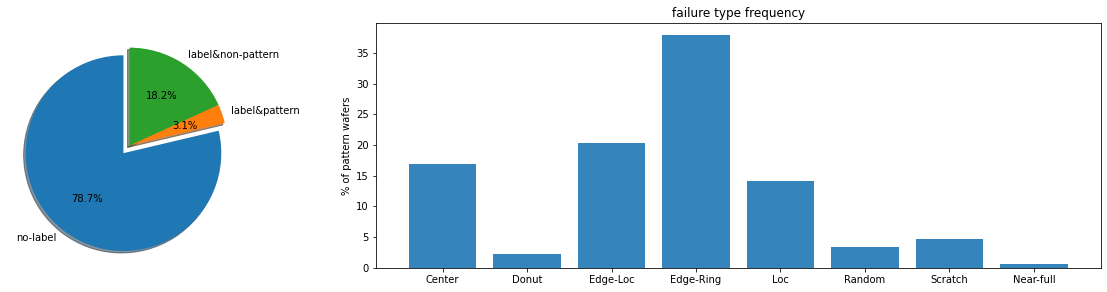

In [8]:
df_withlabel = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 8)]
df_withlabel = df_withlabel.reset_index()
df_withpattern = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum'] == 8)]

fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

tol_wafers = df.shape[0]
no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

explode = (0.1, 0, 0)
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

uni_pattern = np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],(uni_pattern[1]/df_withpattern.shape[0])*100, align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In summary, 172,950 wafers have labels while 78.7% wafers with no label based on failureType variable filtering. Among labeled wafer, only 3.1% wafers (25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none. As a result, we only focus on thoes 25,519 instances which heavily reduce the calculated amount for our work. From the second picture shown above, the dataset shows high imbalance distribution.

## 4. Exploratory Data Analysis
### 4-1. Visualization of wafer maps
Next, we show the first 100 samples with pattern labeled from our datasets.

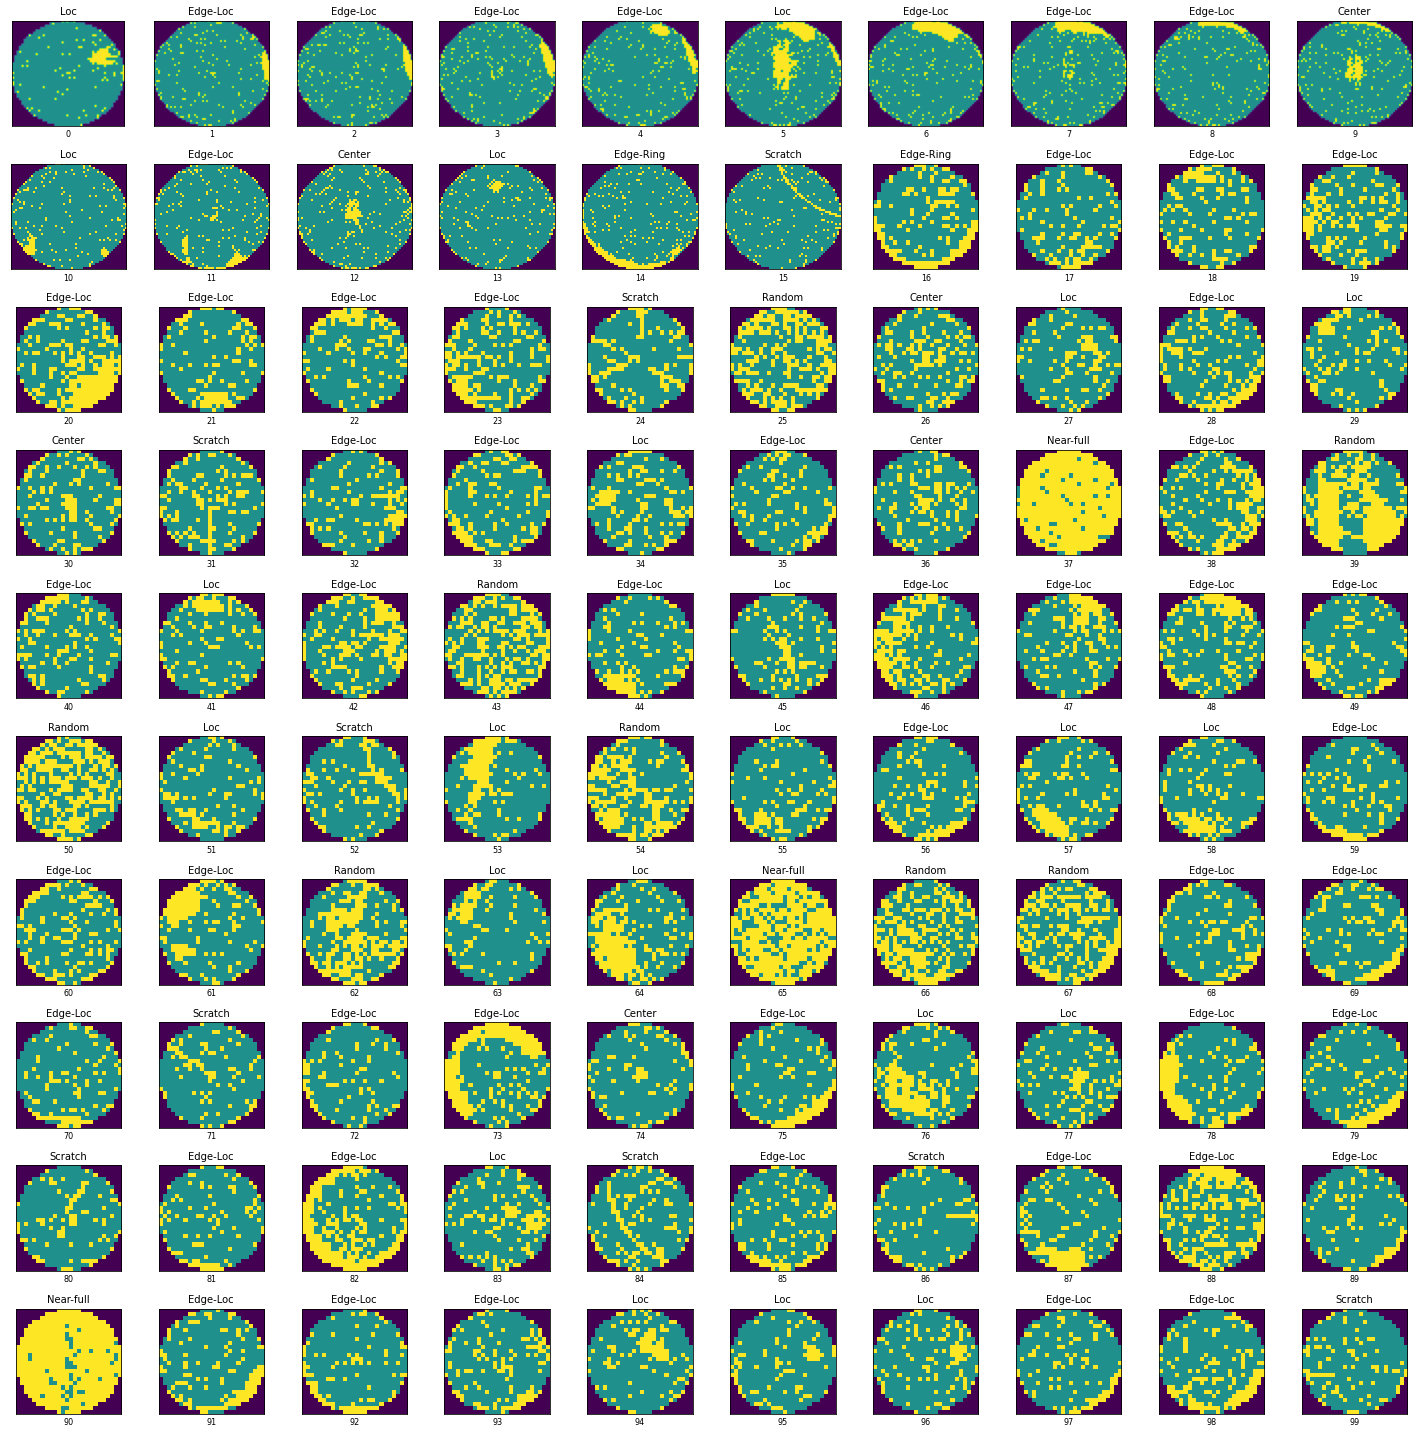

In [9]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

You can also view wafer maps by failure patterns such as center, donut, edge lock, edge ring, lock, random, scratch, and near full.

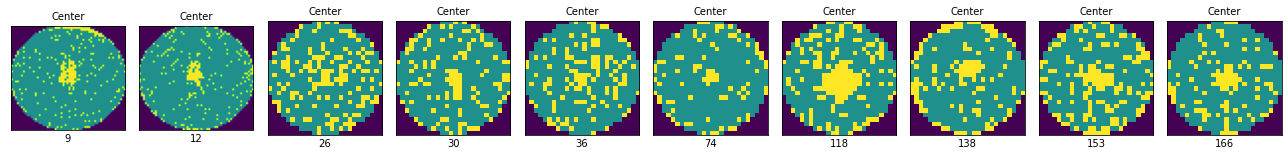

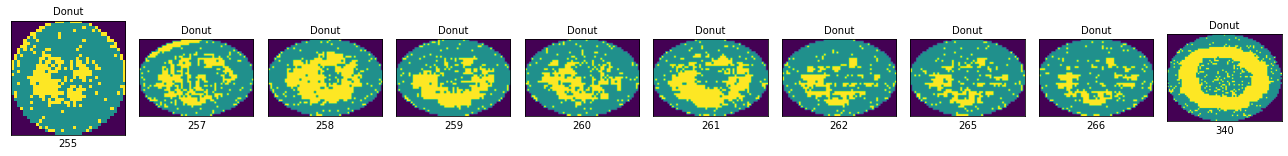

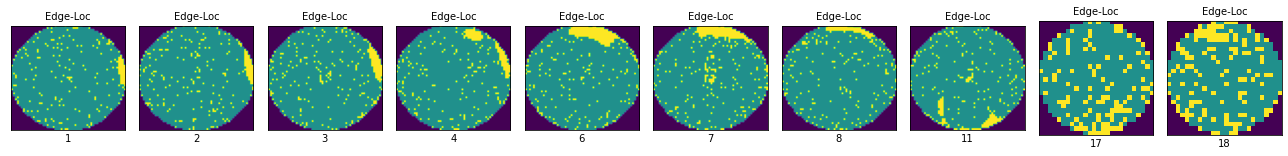

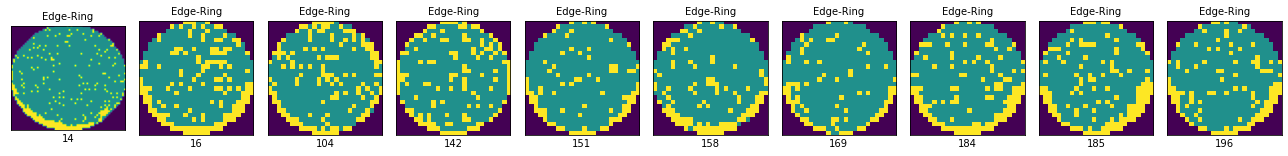

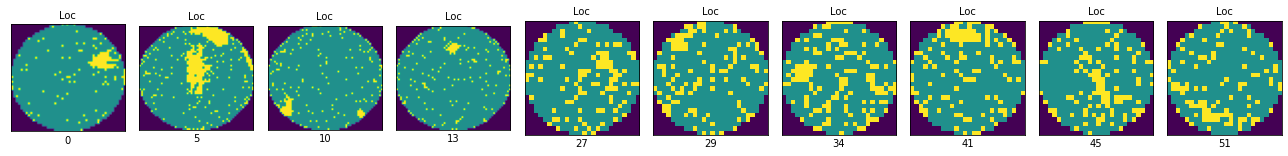

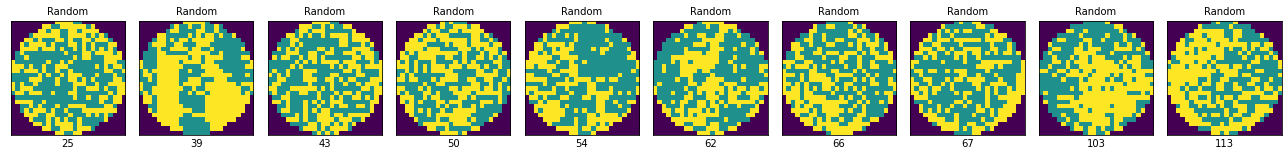

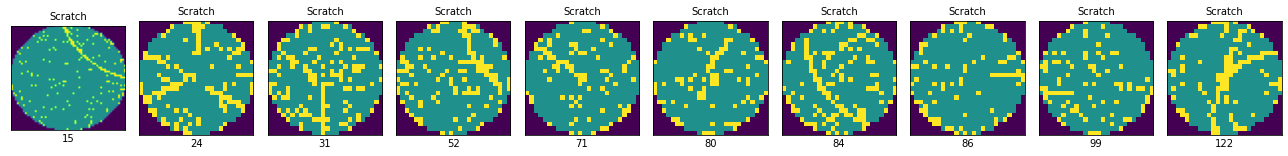

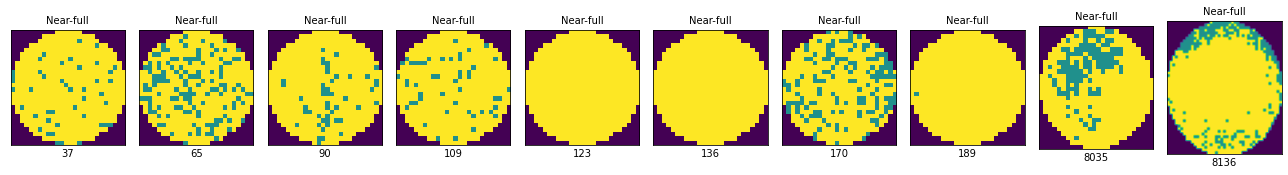

In [10]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In this modeling, feature quantities are generated from the defect distribution in the wafer surface, and labels ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full').

### 4-2. Feature engineering
Pattern recognition requires effective feature engineering. In this project, we extract reduced identifying features from each wafer map and apply them for subsequent classification and analysis. Feature engineering uses a combination of three methods. The first is density-based features, which divide the wafer into regions and use the density as the feature. The second is Radon-based features, which extracts features based on projections of the wafer map along various directions. The third is Geometry-based features, which extracts features based on geometric measurements of the area obtained from the wafer map. By connecting these feature quantities, the features of each wafer map are comprehensively expressed.

**4-2-1. Density-based features**

Divided wafer map into 13 parts and computed defects density accordingly. The 13 regions includes the inner 9 same regions and the top, bottom, left and right regions. For each failure type, it has different density distribution patterns. For example, the center one of the inner 9 regions  will have high defects density for Center failure type.

In [11]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [12]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

Visualize the feature values using typical patterns of each label as an example.

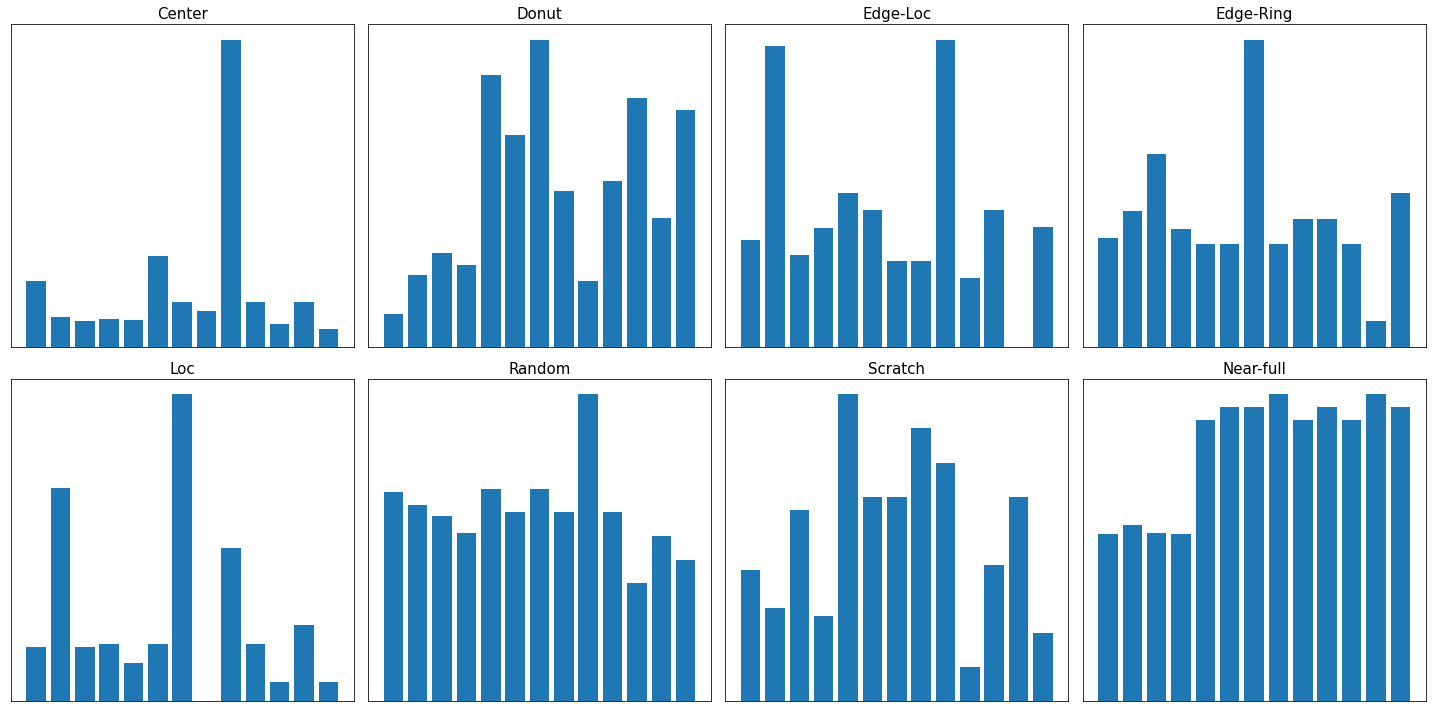

In [13]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
labels = ['reg1', 'reg2', 'reg3', 'reg4', 'reg5', 'reg6', 'reg7', 'reg8',' reg9', 'reg10', 'reg11', 'reg12', 'reg13']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticklabels(labels)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

The picture above shows density based features for 8 typical failure types. It turns out that extracting density based feature is resonable and making the dataset more classifiable. For example, for 'center' and 'loc', you can see areas where the feature values are large locally, and for 'near-full', the feature values are large overall.

**4-2-2. Randon-based features**

Radon-based features are based on the Radon transform, which has been successfully used in computed tomography for medical applications. The Radon transform can generate his 2D representation of his map on the wafer according to a series of projections.

In [14]:
def change_val(img):
    img[img==1] = 0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] = df_withpattern_copy.waferMap.apply(change_val)

Visualize the feature values using typical patterns of each label as an example.

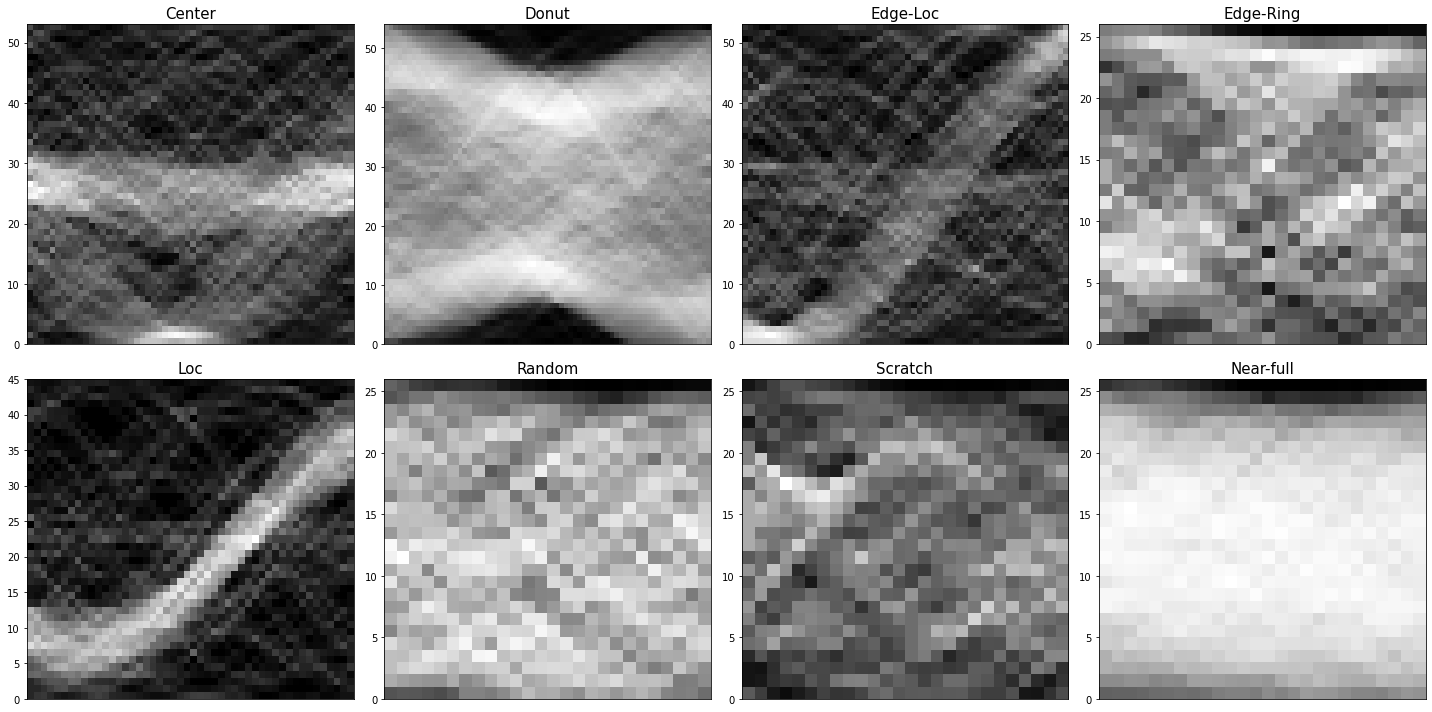

In [15]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

The picture above shows radon tranform results for 8 typical failure types. However, even we obtained radon transform values, we can not regard as features because the wafer vary in size. so in the next step, we using cubic interpolation to obtain fixed dimension feature values for row mean and row standard deviation from radon transform, for each one the dimension is fixed to 20. In total, we extracted 40 dimensions for radon-based features.

In [16]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)
    return ynew  

In [17]:
df_withpattern_copy['fea_cub_mean'] = df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] = df_withpattern_copy.waferMap.apply(cubic_inter_std)

Here is Radon-based feature (interpolate from row mean).

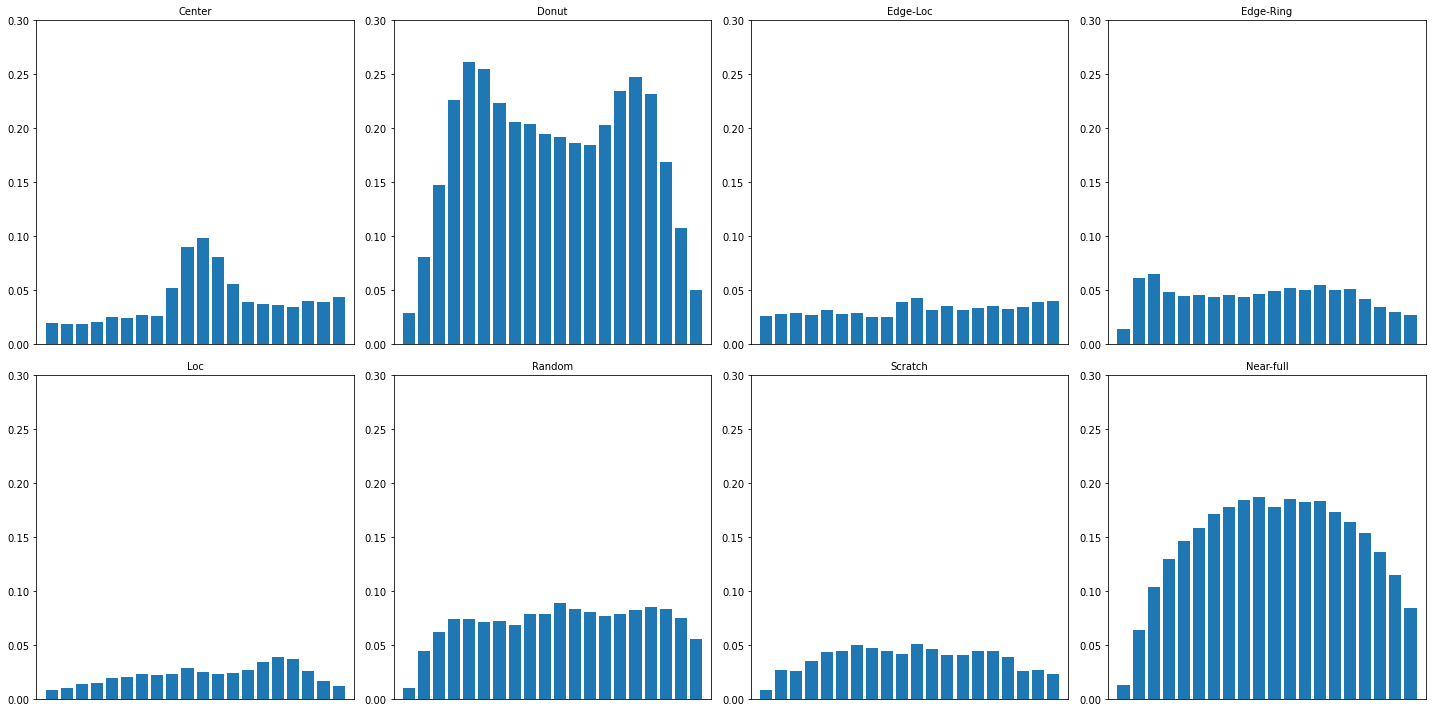

In [18]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc','Random', 'Scratch', 'Near-full']

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20), df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

Here is Radon-based feature (interpolate from row standard deviation).

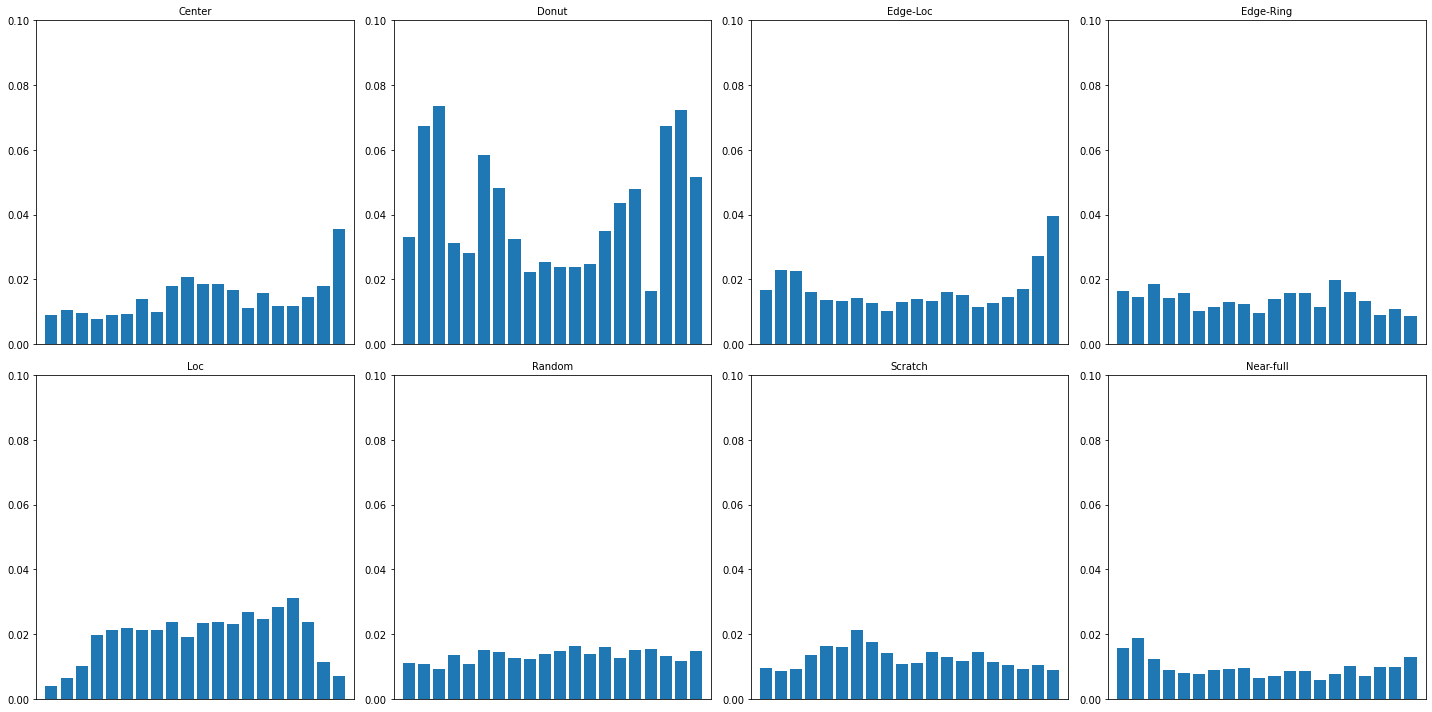

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20), df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.1])
plt.tight_layout()
plt.show() 

A characteristic trend can be confirmed for the average values for 'center', 'donut', and 'near-full'. Also, for standard deviation, you can check the characteristics with 'donut' and 'loc'.

**4-2-3. Geometry-based features**

Most salient region identifying can be regarded as noise filtering. In this work, we use region-labeling algorithm and choose the max area region as the most salient one. Based on the salient region, we try to extract geometry features like area, perimeter, length of major axes,  length of minor axes, solidity and eccentricity. Geometry-based features are used to measure the geometric attributes of each wafer map. Based on observations of numerous wafer maps and consultation with domain experts, geometry-based features are obtained by calculating area, statistical, and linear attributes. All these attributes are rotation and scale invariant. Visualize the feature values using typical patterns of each label as an example.

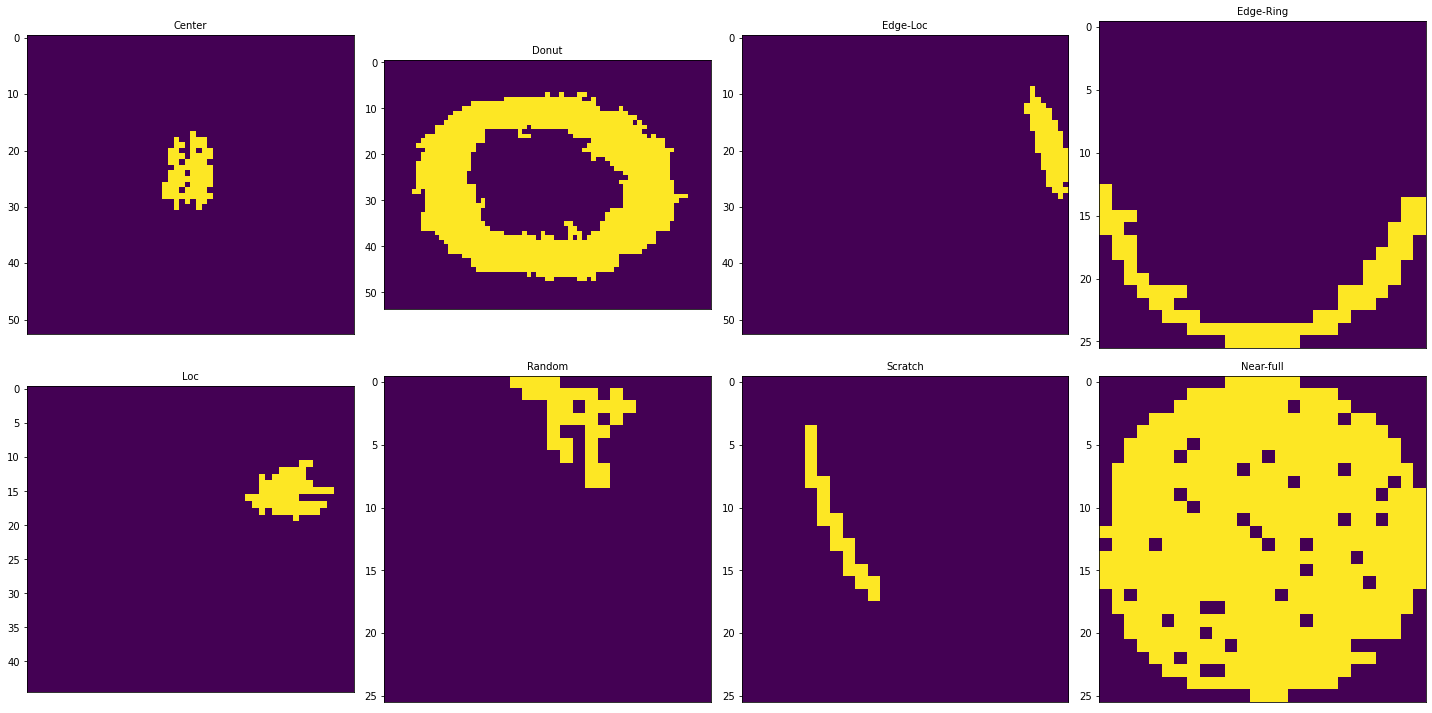

In [20]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, connectivity=1, background=0)
    img_labels = img_labels - 1
    if img_labels.max() == 0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis=None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels == no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

A remarkable noise filtering effect can be confirmed, and the characteristics of each defect pattern can be clearly confirmed.

The following 'fea_geom' function computes geometric features for the given image img. Specifically, we are calculating the following features:
- Area (prop_area): The area of a region in the image normalized by the total area.
- Perimeter (prop_perimeter): Perimeter of the area in the image, normalized by the diagonal length.
- (Distance from center (prop_cent): The distance from the centroid of the region to the center of the image.)
- Major axis length (prop_majaxis): The value obtained by normalizing the length of the major axis of the area by the length of the diagonal.
- Short axis length (prop_minaxis): The value obtained by normalizing the length of the short axis of the area by the length of the diagonal.
- Eccentricity (prop_ecc): Eccentricity of the area.
- Area ratio (prop_solidity): Area ratio of the area.

These features are used as feature quantities.

In [21]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        #no_region = info_region[0][0] - 1
        no_region = info_region[0] - 1 
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] = df_withpattern_copy.waferMap.apply(fea_geom)

**4-2-4. Combine all features together**

We will combine all the above features and do analysis with 59 features.

| feature engineering | # of features |
| :---: | :---: |
| density-based features | 13 |
| radon-based features | 40 |
| geom-based features | 6 |
| total  | 59 | 

In [22]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [23]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

In [24]:
# the shape of features and labels
fea_all.shape, label.shape

((25519, 59), (25519,))

## 5. Models

The task of this project is a supervised identification problem. As a model, we use Random Forest, which is effective even when the muti-class classification and can be efficiently identified even with relatively small amounts of data compared to deep learning models. We will also apply LightGBM and XGBoost, which has achieved excellent results in data analysis competitions in recent years, for comparison.

### 5-1. Preparation for modeling
**5-1-1. Handling Multicollinearity**

First check the correlation matrix for multicollinearity effects. Multicollinearity is an important problem in regression problems, especially linear regression. However, multicollinearity must also be considered in classification problems. Multicollinearity occurs when there is high correlation between features and can affect the interpretability and stability of the model.

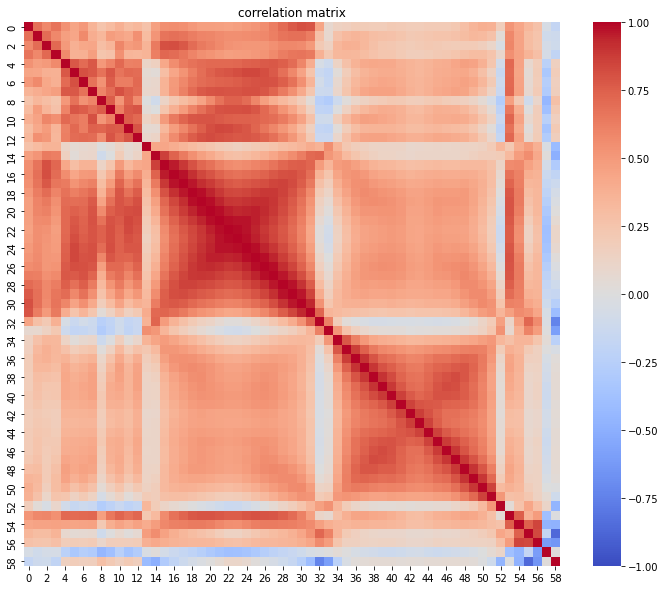

In [25]:
# correlation matrix
fea_all = pd.DataFrame(fea_all)
corr_matrix = fea_all.corr()

# heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('correlation matrix')
plt.show()

In [26]:
# set diagonal term to 0
np.fill_diagonal(corr_matrix.values, 0)

# Extract elements with absolute value of correlation coefficient of 0.95 or more
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.95:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_pairs

[(15, 16, 0.9550302214624867),
 (16, 17, 0.9705852493770981),
 (17, 18, 0.9686321425192608),
 (18, 19, 0.9774106487072204),
 (19, 20, 0.9790158910110967),
 (20, 21, 0.9797719728209819),
 (21, 22, 0.9842616581566016),
 (21, 23, 0.9731016781330304),
 (21, 24, 0.9708898973531901),
 (21, 25, 0.950616938087812),
 (22, 23, 0.9902877469690449),
 (22, 24, 0.9753068320494642),
 (23, 24, 0.9839040148967387),
 (23, 25, 0.9501321835444568),
 (24, 25, 0.9805833714116754),
 (25, 26, 0.9790921473532966),
 (26, 27, 0.9784455926067352),
 (27, 28, 0.968203552799366),
 (28, 29, 0.9737151020322267),
 (29, 30, 0.9636383270179549)]

In [27]:
column_to_drop = [16,18,20,22,23,24,25,27,29]
fea_all = fea_all.drop(columns=column_to_drop, axis=1)

Check the cocorrelation matrix again with the effect of multicollinearity removed.

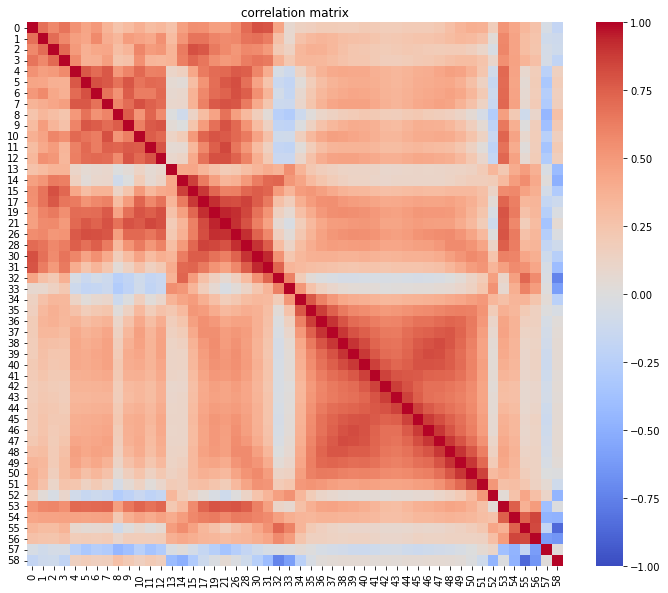

[]

In [28]:
# correlation matrix
corr_matrix = fea_all.corr()

# heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('correlation matrix')
plt.show()

# set diagonal term to 0
np.fill_diagonal(corr_matrix.values, 0)

# Extract elements with absolute value of correlation coefficient of 0.95 or more
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.95:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_pairs

In [29]:
fea_all.shape

(25519, 50)

Elements with absolute correlation coefficient values of 0.95 or greater were removed to eliminate the effects of multicollinearity. This corresponds to about 10 or more in VIF. The number of features is reduced 50 from 59.

**5-1-2. Reduce overfitting**

Split the data into training data and test data to prevent overfitting, and evaluate model accuracy on the test data. Also, during model fitting, cross validation is performed through GridsearchCV to reduce overfitting.

In [30]:
X = fea_all
y = label
X_train_org, X_test, y_train_org, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)              
print('Training target statistics: {}'.format(Counter(y_train_org)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({3: 7744, 2: 4151, 0: 3435, 4: 2874, 6: 955, 5: 693, 1: 444, 7: 119})
Testing target statistics: Counter({3: 1936, 2: 1038, 0: 859, 4: 719, 6: 238, 5: 173, 1: 111, 7: 30})


**5-1-3. Data imbalance**

Interpolate the data imbalance using the following oversampling using SMOTE. Oversampling is typically applied only to training data and not to test data. Therefore, first, we will split the training data and test data.

In [31]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_org, y_train_org)
print('X_train_org shape: ', X_train_org.shape, ', y_train_org shape: ', y_train_org.shape)
print('X_train shape: ', X_train.shape, ', y_train shape: ', y_train.shape, '\n')
y_series = pd.Series(y_train)
class_counts = y_series.value_counts()
print('# of each class')
print(class_counts)

X_train_org shape:  (20415, 50) , y_train_org shape:  (20415,)
X_train shape:  (61952, 50) , y_train shape:  (61952,) 

# of each class
3    7744
0    7744
6    7744
2    7744
5    7744
1    7744
4    7744
7    7744
dtype: int64


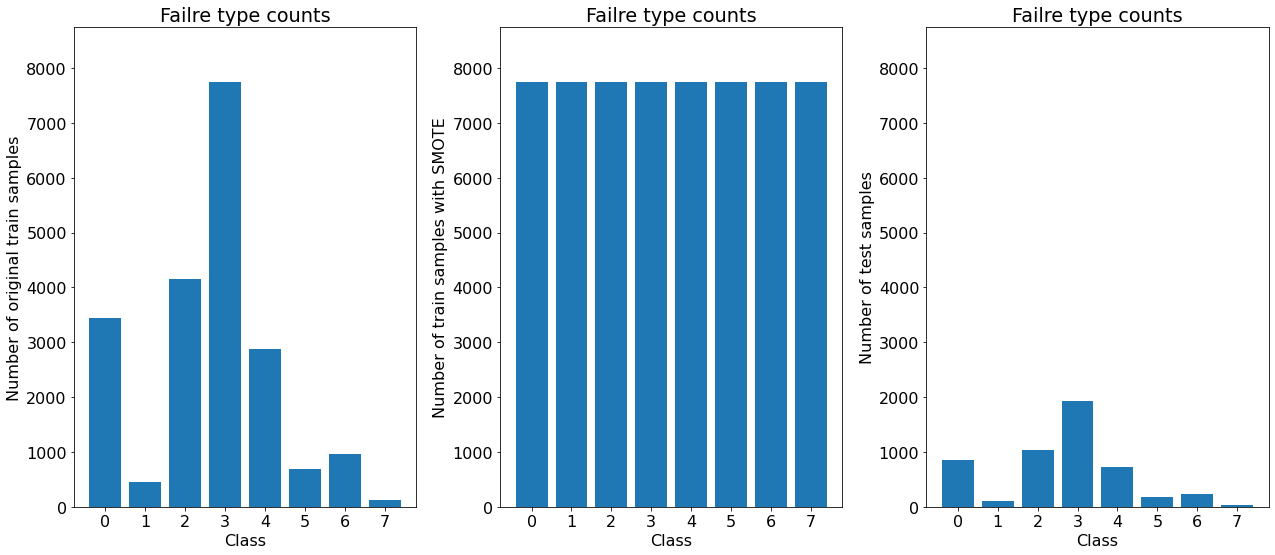

In [48]:
y_org_series = pd.Series(y_train_org)
org_class_counts = y_org_series.value_counts()

y_test_series = pd.Series(y_test)
test_class_counts = y_test_series.value_counts()

max_y = max(org_class_counts.max(), class_counts.max(), test_class_counts.max()) + 1000

plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 16})

plt.subplot(1, 3, 1)
plt.bar(org_class_counts.index, org_class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of original train samples')
plt.title('Failre type counts')
plt.ylim(0, max_y)
plt.xticks(np.arange(min(org_class_counts.index), max(org_class_counts.index)+1, 1))

plt.subplot(1, 3, 2)
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of train samples with SMOTE')
plt.title('Failre type counts')
plt.ylim(0, max_y)
plt.xticks(np.arange(min(class_counts.index), max(class_counts.index)+1, 1))

plt.subplot(1, 3, 3)
plt.bar(test_class_counts.index, test_class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of test samples')
plt.title('Failre type counts')
plt.ylim(0, max_y)
plt.xticks(np.arange(min(test_class_counts.index), max(test_class_counts.index)+1, 1))

plt.tight_layout()
plt.show()

SMOTE aligned the number of samples for each defect pattern class.

### 5-2. Modeling
**5-2-1. Random Forest**

This project implements multiclass and multilabel learning algorithms. First, we choose Random Forest. GridsearchCV is used to tune the hyperparameters, but due to the limitations of the computer's computing power, we will narrow down the parameters and perform optimization. In the case of actual industrial application, it is necessary to use high-performance hardware and perform sufficient parameter assignment. The final code describes the parameters of the best model obtained with GridsearchCV.

In [32]:
# Record the start time of the process
start_time = time.time()

# Define parameter grid for Random Forest
param_grid = {'n_estimators': [200], #[100, 200],
              'max_depth': [None], #[None, 10, 20],
              #'min_samples_split': [2, 5, 10],
              #'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto'],} #['auto', 'sqrt'],

# Create RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Hyperparameter search using GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtain the optimal model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Training and assessment
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_acc = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]

# Record the end time of processing
end_time = time.time()

# Calculate processing time (in seconds)
elapsed_time = end_time - start_time

In [33]:
print("best train accuracy: {}".format(train_acc))
print("best test accuracy: {}".format(test_acc))
print("best model: {}".format(best_model))
print("best parameters: {}".format(best_params))
print(f"processing time: {elapsed_time} sec")

best train accuracy: 0.9999677169421488
best test accuracy: 0.9026253918495298
best model: RandomForestClassifier(n_estimators=200, random_state=42)
best parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
processing time: 388.26046323776245 sec


best train accuracy: 0.9999677169421488  
best test accuracy: 0.9026253918495298  
best model: RandomForestClassifier(n_estimators=200, random_state=42)  
best parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}  
processing time: 388.26046323776245 sec

**5-2-2. XGBoost**

Along with LightGBM, XGBoost is also a very powerful model and will be evaluated.

In [34]:
# Record the start time of the process
start_time = time.time()

# Define parameter grid
param_grid = {'max_depth': [12], #[6, 12],
              'n_estimators': [200], #[100, 200],
              'learning_rate': [0.2]} #[0.1, 0.2]}

# Create XGBClassifier
xgboost = XGBClassifier(random_state=42)

# Hyperparameter search using GridSearchCV
grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtain the optimal model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Training and assessment
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_acc = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]

# Record the end time of processing
end_time = time.time()

# Calculate processing time (in seconds)
elapsed_time = end_time - start_time

In [35]:
print("best train accuracy: {}".format(train_acc))
print("best test accuracy: {}".format(test_acc))
print("best model: {}".format(best_model))
print("best parameters: {}".format(best_params))
print(f"processing time: {elapsed_time} sec")

best train accuracy: 0.9999677169421488
best test accuracy: 0.9135971786833855
best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
best parameters: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 200}
processing time: 674.7920279502869 sec


best train accuracy: 0.9999677169421488  
best test accuracy: 0.9135971786833855  
best model: XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None,  
              colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None,  
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.2, max_bin=None,  
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=12, max_leaves=None,  
              min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=200, n_jobs=None, num_parallel_tree=None,  
              objective='multi:softprob', predictor=None, ...)  
best parameters: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 200}  
processing time: 674.7920279502869 sec

**5-2-3. LightGBM**

Next, we evaluate LightGBM, which is strong against table data and exhibits very high performance in both classification and regression.

In [42]:
# Record the start time of the process
start_time = time.time()

# Define parameter grid
param_grid = {'num_leaves': [63], #[31, 63],
              'n_estimators': [200], #[100, 200],
              'learning_rate': [0.2],} #[0.1, 0.2]}

# Create LGBMClassifier
lgbm = LGBMClassifier(random_state=42, force_row_wise=True, verbose=-1)

# Hyperparameter search using GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtain the optimal model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Training and assessment
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_acc = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]

# Record the end time of processing
end_time = time.time()

# Calculate processing time (in seconds)
elapsed_time = end_time - start_time

In [43]:
print("best train accuracy: {}".format(train_acc))
print("best test accuracy: {}".format(test_acc))
print("best model: {}".format(best_model))
print("best parameters: {}".format(best_params))
print(f"processing time: {elapsed_time} sec")

best train accuracy: 0.9999677169421488
best test accuracy: 0.9181034482758621
best model: LGBMClassifier(force_row_wise=True, learning_rate=0.2, n_estimators=200,
               num_leaves=63, random_state=42, verbose=-1)
best parameters: {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 63}
processing time: 65.06042170524597 sec


best train accuracy: 0.9999677169421488  
best test accuracy: 0.9181034482758621  
best model: LGBMClassifier(force_row_wise=True, learning_rate=0.2, n_estimators=200, num_leaves=63, random_state=42)  
best parameters: {'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 63}  
processing time: 65.06042170524597 sec

**5-2-4. Feature importance of the best model**

The feature importance of the best model of LightGBM, which has the highest accuracy in identifying test data, is shown below.

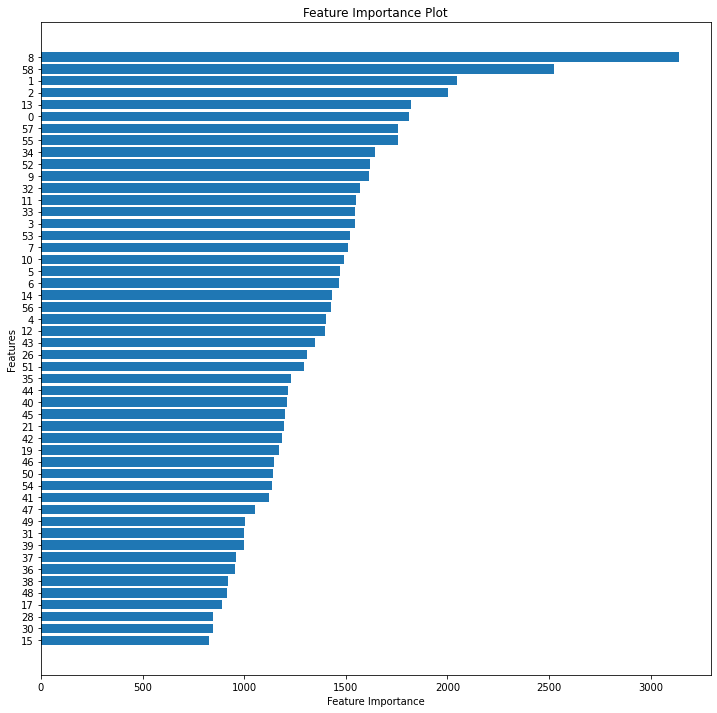

In [38]:
# Obtain feature importances from the best model
feature_importance = best_model.feature_importances_

# Map feature importances to feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns  # Replace with your feature names or column names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importances in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Extract feature names and importances as separate lists
sorted_feature_names = list(sorted_feature_importance.keys())
sorted_feature_importances = list(sorted_feature_importance.values())

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importances)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)  # Set y-axis labels to feature names
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

It can be confirmed that the feature importance of features 8 and 58 is outstanding. Feature 8, which has the highest feature importance, is the density at the center of the wafer. Also, feature 58 shows eccentricity.

## 6. Results and Analysis
**Summary of the models**

Three decision tree-based bagging and boosting models (Random Forest, XGBoost, and LightGBM) were applied to a multi-class classification problem. All models showed high discrimination performance. Among them, LightGBM had the highest prediction accuracy on test data, achieving 91.81%. In terms of model training time, LightGBM is also overwhelmingly shorter and superior in terms of learning efficiency.

| model | training accuracy | test accuracy | processing time |
| :---: | :---: | :---: | :---: |
| Random Forest | 0.99997 | <span style="color: red">0.90263</span> | 388.3 sec |
| XGBoost | 0.99997 | <span style="color: red">0.91360</span> | 674.8 sec |
| **LightGBM** | 0.99997 | **<span style="color: red">0.91810</span>** | **65.1 sec** |

Since the original data has been confirmed to have an imbalance in the classification classes, we check not only the classification accuracy but also the validity of the model accuracy using the confusion matrix.

In [39]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   

LGBMClassifier(force_row_wise=True, learning_rate=0.2, n_estimators=200,
               num_leaves=63, random_state=42)
Confusion matrix, without normalization
Normalized confusion matrix


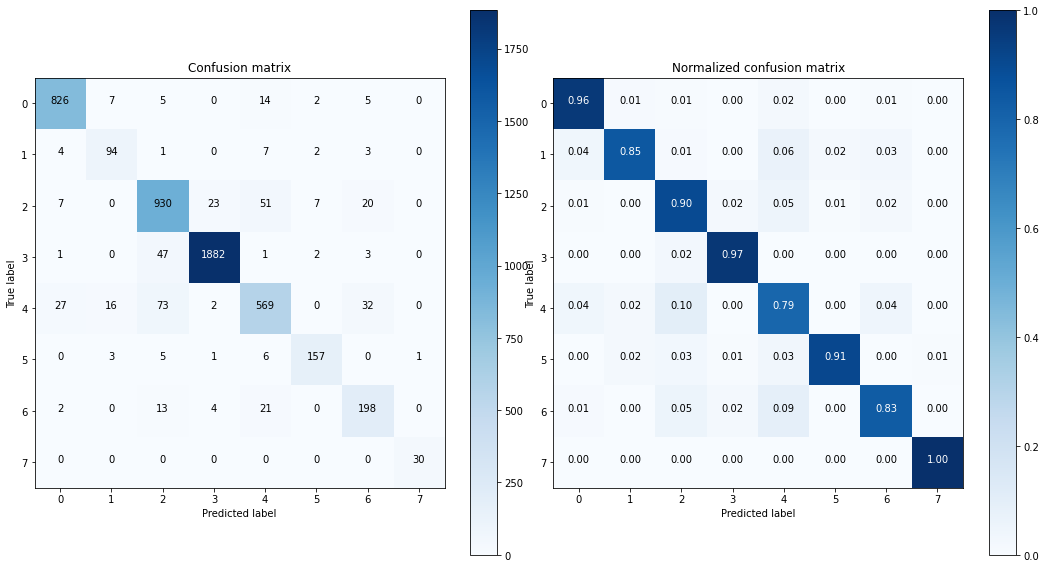

In [40]:
# Prediction using the best model 
print(best_model)
y_test_pred = best_model.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

The probability of predicting {4: 'Edge-Ring'} incorrectly as {2: 'Donut'} is highest. It is true that these two classes have similar tendencies, and although experts can tell them apart, it can be expected to be difficult for machine learning. Below is a comprehensive summary of accuracy, recall, f1_score, etc. Although the numbers vary depending on the class, overall high performance is achieved for each metric.

In [41]:
# Generate a classification report
report = classification_report(y_test, y_test_pred)

# View report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       859
           1       0.78      0.85      0.81       111
           2       0.87      0.90      0.88      1038
           3       0.98      0.97      0.98      1936
           4       0.85      0.79      0.82       719
           5       0.92      0.91      0.92       173
           6       0.76      0.83      0.79       238
           7       0.97      1.00      0.98        30

    accuracy                           0.92      5104
   macro avg       0.89      0.90      0.89      5104
weighted avg       0.92      0.92      0.92      5104



In order to improve the identification performance, hyperparameter optimization was performed using grid search. Due to computer performance and time constraints, we narrowed down the adjustment range of parameters. For actual industrial applications, it is necessary to optimize hyperparameters more carefully. Also, if grid search takes time, it is necessary to consider random search.

## 7. Discussion and Conclusion

- In this project, the characteristics of defects were identified from defect patterns on semiconductor wafers, and the core technology for yield improvement was investigated.
- Random Forest, XGBoost, and LightGBM were applied to multi-class identification problems regarding defective topological patterns.
- Each model achieved high accuracy exceeding 90%. In particular, LightGBM achieved the highest accuracy of 91.81% and faster learning time. It is a level that can withstand practical use.
- In order to improve model accuracy, we applied various feature engineering (Density-based, Radon-based, and Geometry-based) and optimized hyperparameters. However, in actual industrial applications, hyperparameter optimization needs to be performed more extensively.
- Future tasks are further optimization of hyperparameters and improvement of accuracy by applying deep learning methods such as CNN.

## References
[1] M. -J. Wu, J. -S. R. Jang and J. -L. Chen, "Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets," in *IEEE Transactions on Semiconductor Manufacturing*, vol. 28, no. 1, pp. 1-12, Feb. 2015, doi: 10.1109/TSM.2014.2364237.

[2] Mengying Fan, Qin Wang and B. van der Waal, "Wafer defect patterns recognition based on OPTICS and multi-label classification," *2016 IEEE Advanced Information Management, Communicates, Electronic and Automation Control Conference (IMCEC)*, Xi'an, China, 2016, pp. 912-915, doi: 10.1109/IMCEC.2016.7867343.

[3] Dataset, http://mirlab.org/dataSet/public/, or https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map

[4] Wikipedia contributors. (2023, August 15). Radon transform. In Wikipedia, The Free Encyclopedia. Retrieved 01:00, September 2, 2023, from https://en.wikipedia.org/w/index.php?title=Radon_transform&oldid=1170586091

[5] Chawla, N. V.; Bowyer, K. W.; Hall, L. O.; Kegelmeyer, W. P. (2002-06-01). "SMOTE: Synthetic Minority Over-sampling Technique". *Journal of Artificial Intelligence Research.* 16: 321–357. arXiv:1106.1813. doi:10.1613/jair.953. ISSN 1076-9757. S2CID 1554582.

[6] Breiman, Leo (2001). “Random Forests”. *Machine Learning* 45 (1): 5–32. doi:10.1023/A:1010933404324.

[7] Brownlee, Jason (March 31, 2020). "Gradient Boosting with Scikit-Learn, XGBoost, LightGBM, and CatBoost".

[8] GitHub repository, https://github.com/DaisakuIkoma/CU_MSDS_SVML.git.